In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import transforms


from lib.custmized_layer import convLayer, poolLayer, denseLayer
from lib.datasets.spikedataset import SpikeDataset, transform_cifar

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# some handy function to use
from lib.utils import save_model, load_dict, load_model, test_method, get_labels

# Test for raw and tailored CNN
Following tasks are done:
1. train and test for MNIST datast with raw_cnn and talor_cnn.
2. the same work for FashionMnist, and with the same set-up for network structure, since the input has the same size, and problems are similar. Besides, we want to show the difference of performance between the 3 networks, raw, tailored and snn with weights from tailored cnn. A network with smaller size can hugely  accelerate this pipeline.
3. 

In [3]:
# set up hyper params
BATCH_SIZE  = 32

EPOCH = 100

NUM_WORKERS = 2

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
def plot_stats(stats):
    plt.figure(1)
    plt.semilogy(stats.training.lossLog, label='Training')
    plt.semilogy(stats.testing.lossLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(2)
    plt.plot(stats.training.accuracyLog, label='Training')
    plt.plot(stats.testing.accuracyLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Training
def train(model, model_name, trainloader, testloader, criterion, optimizer, stats, epoch):
    
    for epoch in tqdm(range(epoch)):
        # Reset training stats.
        stats.training.reset()
        tSt = datetime.now()
        model.train()    
        # Training loop.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Gather the training stats.
            _, predicted = torch.max(outputs.data, 1)

            stats.training.correctSamples += torch.sum(predicted == labels).data.item()
            stats.training.numSamples += len(labels)

            # Display training stats.
            # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        # Update training stats.
        stats.training.update()
        # Reset testing stats.
        stats.testing.reset()
        model.eval()    
        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)

            stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
            stats.testing.numSamples += len(labels)

            loss = criterion(outputs, labels)
            stats.testing.lossSum += loss.cpu().data.item()


        # Update stats.
        stats.testing.update()
        if epoch%2==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    print('Finished Training')
    
    #test_acc(testloader, model)
    plot_stats(stats)
    save_model(model_name, model)

## Training for CNNs
* define the two CNNs
* define the train function
* train them and check the results

In [5]:
class Raw_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Raw_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.m1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.m2(x) 
        x = x.view(-1, 12 * 5 * 5)    
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN_Mnist(nn.Module):
    def __init__(self):
        super(Tailored_CNN_Mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.a1(x)
        x = F.relu(self.conv2(x))
        x = self.a2(x)
        x = x.view(-1, 12 * 5 * 5)   
        x = self.fc1(x) 
        return F.log_softmax(x, dim=1)
    
# the learningStat class    
class learningStat():
    '''
    This class collect the learning statistics over the epoch.

    Usage:

    This class is designed to be used with learningStats instance although it can be used separately.

    >>> trainingStat = learningStat()
    '''
    def __init__(self):
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0
        self.minloss = None
        self.maxAccuracy = None
        self.lossLog = []
        self.accuracyLog = []
        self.bestLoss = False
        self.bestAccuracy = False

    def reset(self):
        '''
        Reset the learning staistics. 
        This should usually be done before the start of an epoch so that new statistics counts can be accumulated.

        Usage:

        >>> trainingStat.reset()
        '''
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0

    def loss(self):
        '''
        Returns the average loss calculated from the point the stats was reset.

        Usage:

        >>> loss = trainingStat.loss()
        '''
        if self.numSamples > 0: 
            return self.lossSum/self.numSamples 
        else:   
            return None

    def accuracy(self):
        '''
        Returns the average accuracy calculated from the point the stats was reset.

        Usage:

        >>> accuracy = trainingStat.accuracy()
        '''
        if self.numSamples > 0 and self.correctSamples > 0:
            return self.correctSamples/self.numSamples  
        else:   
            return None

    def update(self):
        '''
        Updates the stats of the current session and resets the measures for next session.

        Usage:

        >>> trainingStat.update()
        '''
        currentLoss = self.loss()
        self.lossLog.append(currentLoss)
        if self.minloss is None:
            self.minloss = currentLoss
        else:
            if currentLoss < self.minloss:
                self.minloss = currentLoss
                self.bestLoss = True
            else:
                self.bestLoss = False
            # self.minloss = self.minloss if self.minloss < currentLoss else currentLoss

        currentAccuracy = self.accuracy()
        self.accuracyLog.append(currentAccuracy)
        if self.maxAccuracy is None:
            self.maxAccuracy = currentAccuracy
        else:
            if currentAccuracy > self.maxAccuracy:
                self.maxAccuracy = currentAccuracy
                self.bestAccuracy = True
            else:
                self.bestAccuracy = False
            # self.maxAccuracy = self.maxAccuracy if self.maxAccuracy > currentAccuracy else currentAccuracy

    def displayString(self):
        loss = self.loss()
        accuracy = self.accuracy()
        minloss = self.minloss
        maxAccuracy = self.maxAccuracy

        if loss is None:    # no stats available
            return None
        elif accuracy is None: 
            if minloss is None: # accuracy and minloss stats is not available
                return 'loss = %-12.5g'%(loss)
            else:   # accuracy is not available but minloss is available
                return 'loss = %-12.5g (min = %-12.5g)'%(loss, minloss)
        else:
            if minloss is None and maxAccuracy is None: # minloss and maxAccuracy is available
                return 'loss = %-12.5g        %-12s   \taccuracy = %-10.5g        %-10s '%(loss, ' ', accuracy, ' ')
            else:   # all stats are available
                return 'loss = %-12.5g (min = %-12.5g)  \taccuracy = %-10.5g (max = %-10.5g)'%(loss, minloss, accuracy, maxAccuracy)

class learningStats():
    '''
    This class provides mechanism to collect learning stats for training and testing, and displaying them efficiently.

    Usage:

    .. code-block:: python
    
        stats = learningStats()

        for epoch in range(100):
            tSt = datetime.now()

            stats.training.reset()
            for i in trainingLoop:
                # other main stuffs
                stats.training.correctSamples += numberOfCorrectClassification
                stats.training.numSamples     += numberOfSamplesProcessed
                stats.training.lossSum        += currentLoss
                stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            stats.training.update()

            stats.testing.reset()
            for i in testingLoop
                # other main stuffs
                stats.testing.correctSamples += numberOfCorrectClassification
                stats.testing.numSamples     += numberOfSamplesProcessed
                stats.testing.lossSum        += currentLoss
                stats.print(epoch, i)
            stats.training.update()

    '''
    def __init__(self):
        self.linesPrinted = 0
        self.training = learningStat()
        self.testing  = learningStat()

    def update(self):
        '''
        Updates the stats for training and testing and resets the measures for next session.

        Usage:

        >>> stats.update()
        '''
        self.training.update()
        self.training.reset()
        self.testing.update()
        self.testing.reset()

    def print(self, epoch, iter=None, timeElapsed=None):
        '''
        Prints the available learning statistics from the current session on the console.
        For Linux systems, prints the data on same terminal space (might not work properly on other systems).

        Arguments:
            * ``epoch``: epoch counter to display (required).
            * ``iter``: iteration counter to display (not required).
            * ``timeElapsed``: runtime information (not required).

        Usage:

        .. code-block:: python

            # prints stats with epoch index provided
            stats.print(epoch) 

            # prints stats with epoch index and iteration index provided
            stats.print(epoch, iter=i) 
            
            # prints stats with epoch index, iteration index and time elapsed information provided
            stats.print(epoch, iter=i, timeElapsed=time) 
        '''
        print('\033[%dA'%(self.linesPrinted))
        
        self.linesPrinted = 1

        epochStr   = 'Epoch : %10d'%(epoch)
        iterStr    = '' if iter is None else '(i = %7d)'%(iter)
        profileStr = '' if timeElapsed is None else ', %12.4f ms elapsed'%(timeElapsed * 1000)

        print(epochStr + iterStr + profileStr)
        print(self.training.displayString())
        self.linesPrinted += 2
        if self.testing.displayString() is not None:
            print(self.testing.displayString())
            self.linesPrinted += 1

    def plot(self, figures=(1, 2), saveFig=False, path=''):
        '''
        Plots the available learning statistics.

        Arguments:
            * ``figures``: Index of figure ID to plot on. Default is figure(1) for loss plot and figure(2) for accuracy plot.
            * ``saveFig``(``bool``): flag to save figure into a file.
            * ``path``: path to save the file. Defaule is ``''``.

        Usage:

        .. code-block:: python

            # plot stats
            stats.plot() 

            # plot stats figures specified
            stats.print(figures=(10, 11)) 
        '''
        plt.figure(figures[0])
        plt.cla()
        if len(self.training.lossLog) > 0:
            plt.semilogy(self.training.lossLog, label='Training')
        if len(self.testing.lossLog) > 0:
            plt.semilogy(self.testing .lossLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        if saveFig is True: 
            plt.savefig(path + 'loss.png')
            # plt.close()

        plt.figure(figures[1])
        plt.cla()
        if len(self.training.accuracyLog) > 0:
            plt.plot(self.training.accuracyLog, label='Training')
        if len(self.testing.accuracyLog) > 0:
            plt.plot(self.testing .accuracyLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend() 
        if saveFig is True: 
            plt.savefig(path + 'accuracy.png')
            # plt.close()

    def save(self, filename=''):
        '''
        Saves the learning satatistics logs.

        Arguments:
            * ``filename``: filename to save the logs. ``accuracy.txt`` and ``loss.txt`` will be appended

        Usage:

        .. code-block:: python

            # save stats
            stats.save() 

            # save stats filename specified
            stats.save(filename='Run101-0.001-') # Run101-0.001-accuracy.txt and Run101-0.001-loss.txt
        '''

        with open(filename + 'loss.txt', 'wt') as loss:
            loss.write('#%11s %11s\r\n'%('Train', 'Test'))
            for i in range(len(self.training.lossLog)): 
                loss.write('%12.6g %12.6g \r\n'%(self.training.lossLog[i], self.testing.lossLog[i]))

        with open(filename + 'accuracy.txt', 'wt') as accuracy:
            accuracy.write('#%11s %11s\r\n'%('Train', 'Test'))
            if self.training.accuracyLog != [None]*len(self.training.accuracyLog):
                for i in range(len(self.training.accuracyLog)): 
                    accuracy.write('%12.6g %12.6g \r\n'%(self.training.accuracyLog[i], self.testing.accuracyLog[i]))

### experiment MNIST

In [6]:
# trainset_cnn = MNIST(root='./data', train=True, transform=transforms.Compose([
#             transforms.ToTensor()]))

# trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=NUM_WORKERS)

# testset_cnn = MNIST(root='./data', train=False, transform=transforms.Compose([
#             transforms.ToTensor()]))

# testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
#                                          shuffle=False, num_workers=NUM_WORKERS)

In [6]:
class MNIST500(Dataset):
    def __init__(self, datasetPath, train=False):
        self.path = datasetPath
        ds = MNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
            transforms.ToTensor()]))
        self.samples = [ds[i] for i in range(0, 500)]

    def __getitem__(self, index):
        x, y = self.samples[index]
        return x, y

    def __len__(self):
        return len(self.samples)

In [7]:
trainset_cnn = MNIST500('./data', train=True)

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = MNIST500('./data', train=False)

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

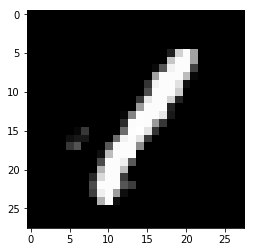

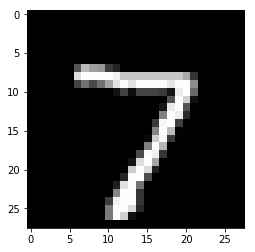

In [8]:
# check if we choose the correct dataset

plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

* train the raw CNN on MNIST

  1%|          | 1/100 [00:00<01:02,  1.58it/s]


Epoch :          0,     632.2520 ms elapsed
loss = 0.073469     (min = 0.073469    )  	accuracy = 0.112      (max = 0.112     )
loss = 0.072803     (min = 0.072803    )  	accuracy = 0.21       (max = 0.21      )


  3%|▎         | 3/100 [00:02<01:06,  1.46it/s]


Epoch :          2,     722.2710 ms elapsed
loss = 0.062846     (min = 0.062846    )  	accuracy = 0.542      (max = 0.542     )
loss = 0.058417     (min = 0.058417    )  	accuracy = 0.576      (max = 0.576     )


  5%|▌         | 5/100 [00:03<01:06,  1.43it/s]


Epoch :          4,     736.4600 ms elapsed
loss = 0.029436     (min = 0.029436    )  	accuracy = 0.772      (max = 0.772     )
loss = 0.032328     (min = 0.032328    )  	accuracy = 0.68       (max = 0.68      )


  7%|▋         | 7/100 [00:04<01:05,  1.42it/s]


Epoch :          6,     677.8260 ms elapsed
loss = 0.017478     (min = 0.017478    )  	accuracy = 0.836      (max = 0.836     )
loss = 0.023781     (min = 0.023781    )  	accuracy = 0.738      (max = 0.738     )


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]


Epoch :          8,     801.8920 ms elapsed
loss = 0.013612     (min = 0.013612    )  	accuracy = 0.88       (max = 0.88      )
loss = 0.018055     (min = 0.018055    )  	accuracy = 0.808      (max = 0.808     )


 11%|█         | 11/100 [00:08<01:08,  1.31it/s]


Epoch :         10,     807.1570 ms elapsed
loss = 0.011132     (min = 0.011132    )  	accuracy = 0.884      (max = 0.89      )
loss = 0.016644     (min = 0.016644    )  	accuracy = 0.82       (max = 0.824     )


 13%|█▎        | 13/100 [00:09<01:04,  1.35it/s]


Epoch :         12,     716.1600 ms elapsed
loss = 0.010154     (min = 0.010154    )  	accuracy = 0.902      (max = 0.902     )
loss = 0.014175     (min = 0.014175    )  	accuracy = 0.842      (max = 0.852     )


 15%|█▌        | 15/100 [00:10<00:58,  1.45it/s]


Epoch :         14,     583.0730 ms elapsed
loss = 0.0081716    (min = 0.0081716   )  	accuracy = 0.922      (max = 0.922     )
loss = 0.012495     (min = 0.012495    )  	accuracy = 0.87       (max = 0.87      )


 17%|█▋        | 17/100 [00:11<00:45,  1.83it/s]


Epoch :         16,     412.1380 ms elapsed
loss = 0.0076602    (min = 0.0075386   )  	accuracy = 0.924      (max = 0.924     )
loss = 0.011679     (min = 0.011679    )  	accuracy = 0.87       (max = 0.87      )


 19%|█▉        | 19/100 [00:12<00:38,  2.12it/s]


Epoch :         18,     391.7520 ms elapsed
loss = 0.0062155    (min = 0.0062155   )  	accuracy = 0.94       (max = 0.94      )
loss = 0.011023     (min = 0.011023    )  	accuracy = 0.884      (max = 0.884     )


 21%|██        | 21/100 [00:13<00:40,  1.94it/s]


Epoch :         20,     655.2990 ms elapsed
loss = 0.0058896    (min = 0.0058896   )  	accuracy = 0.928      (max = 0.94      )
loss = 0.011315     (min = 0.010957    )  	accuracy = 0.882      (max = 0.884     )


 23%|██▎       | 23/100 [00:14<00:48,  1.58it/s]


Epoch :         22,     752.3930 ms elapsed
loss = 0.0049932    (min = 0.0049932   )  	accuracy = 0.946      (max = 0.954     )
loss = 0.010372     (min = 0.010372    )  	accuracy = 0.89       (max = 0.9       )


 25%|██▌       | 25/100 [00:16<00:51,  1.47it/s]


Epoch :         24,     707.9870 ms elapsed
loss = 0.0042211    (min = 0.0042097   )  	accuracy = 0.962      (max = 0.962     )
loss = 0.0093881    (min = 0.0093881   )  	accuracy = 0.908      (max = 0.908     )


 27%|██▋       | 27/100 [00:17<00:50,  1.43it/s]


Epoch :         26,     718.9880 ms elapsed
loss = 0.0038431    (min = 0.0038431   )  	accuracy = 0.96       (max = 0.964     )
loss = 0.0089654    (min = 0.0089654   )  	accuracy = 0.908      (max = 0.908     )


 29%|██▉       | 29/100 [00:19<00:48,  1.46it/s]


Epoch :         28,     663.7850 ms elapsed
loss = 0.0029602    (min = 0.0029602   )  	accuracy = 0.976      (max = 0.976     )
loss = 0.0085276    (min = 0.0085276   )  	accuracy = 0.898      (max = 0.908     )


 31%|███       | 31/100 [00:20<00:48,  1.44it/s]


Epoch :         30,     727.0690 ms elapsed
loss = 0.0022493    (min = 0.0022493   )  	accuracy = 0.982      (max = 0.982     )
loss = 0.0083855    (min = 0.0081012   )  	accuracy = 0.904      (max = 0.918     )


 33%|███▎      | 33/100 [00:21<00:45,  1.46it/s]


Epoch :         32,     665.0870 ms elapsed
loss = 0.0019579    (min = 0.0019579   )  	accuracy = 0.984      (max = 0.986     )
loss = 0.0080874    (min = 0.0080874   )  	accuracy = 0.914      (max = 0.918     )


 35%|███▌      | 35/100 [00:23<00:48,  1.35it/s]


Epoch :         34,     807.3940 ms elapsed
loss = 0.0017175    (min = 0.0017175   )  	accuracy = 0.994      (max = 0.994     )
loss = 0.007873     (min = 0.007873    )  	accuracy = 0.91       (max = 0.918     )


 37%|███▋      | 37/100 [00:25<00:47,  1.33it/s]


Epoch :         36,     704.1720 ms elapsed
loss = 0.0015146    (min = 0.0015146   )  	accuracy = 0.998      (max = 0.998     )
loss = 0.0078643    (min = 0.0078643   )  	accuracy = 0.91       (max = 0.918     )


 39%|███▉      | 39/100 [00:26<00:43,  1.40it/s]


Epoch :         38,     692.8070 ms elapsed
loss = 0.0012776    (min = 0.0012776   )  	accuracy = 0.994      (max = 0.998     )
loss = 0.008325     (min = 0.0078478   )  	accuracy = 0.904      (max = 0.918     )


 41%|████      | 41/100 [00:27<00:42,  1.40it/s]


Epoch :         40,     661.7260 ms elapsed
loss = 0.0010653    (min = 0.0010653   )  	accuracy = 1          (max = 1         )
loss = 0.0080151    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 43%|████▎     | 43/100 [00:29<00:40,  1.41it/s]


Epoch :         42,     710.2150 ms elapsed
loss = 0.00085701   (min = 0.00085701  )  	accuracy = 1          (max = 1         )
loss = 0.0078157    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 45%|████▌     | 45/100 [00:30<00:39,  1.38it/s]


Epoch :         44,     676.5040 ms elapsed
loss = 0.00072819   (min = 0.00072679  )  	accuracy = 1          (max = 1         )
loss = 0.0078288    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 47%|████▋     | 47/100 [00:32<00:39,  1.35it/s]


Epoch :         46,     729.2710 ms elapsed
loss = 0.0005929    (min = 0.0005929   )  	accuracy = 1          (max = 1         )
loss = 0.0076515    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 49%|████▉     | 49/100 [00:33<00:39,  1.30it/s]


Epoch :         48,     835.7460 ms elapsed
loss = 0.00055713   (min = 0.00055713  )  	accuracy = 1          (max = 1         )
loss = 0.0078149    (min = 0.0076      )  	accuracy = 0.916      (max = 0.924     )


 51%|█████     | 51/100 [00:35<00:38,  1.29it/s]


Epoch :         50,     799.2990 ms elapsed
loss = 0.00048284   (min = 0.00048284  )  	accuracy = 1          (max = 1         )
loss = 0.0076811    (min = 0.0076      )  	accuracy = 0.918      (max = 0.924     )


 53%|█████▎    | 53/100 [00:36<00:34,  1.38it/s]


Epoch :         52,     672.3580 ms elapsed
loss = 0.00042659   (min = 0.00042659  )  	accuracy = 1          (max = 1         )
loss = 0.007841     (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 55%|█████▌    | 55/100 [00:38<00:30,  1.47it/s]


Epoch :         54,     657.0710 ms elapsed
loss = 0.00035649   (min = 0.00035649  )  	accuracy = 1          (max = 1         )
loss = 0.0080227    (min = 0.0076      )  	accuracy = 0.92       (max = 0.924     )


 57%|█████▋    | 57/100 [00:39<00:29,  1.46it/s]


Epoch :         56,     677.1290 ms elapsed
loss = 0.00032984   (min = 0.00032984  )  	accuracy = 1          (max = 1         )
loss = 0.0079535    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 59%|█████▉    | 59/100 [00:40<00:29,  1.41it/s]


Epoch :         58,     727.5910 ms elapsed
loss = 0.00029136   (min = 0.00029136  )  	accuracy = 1          (max = 1         )
loss = 0.0079874    (min = 0.0076      )  	accuracy = 0.908      (max = 0.924     )


 61%|██████    | 61/100 [00:42<00:27,  1.44it/s]


Epoch :         60,     650.2730 ms elapsed
loss = 0.00026649   (min = 0.00026649  )  	accuracy = 1          (max = 1         )
loss = 0.0079086    (min = 0.0076      )  	accuracy = 0.916      (max = 0.924     )


 63%|██████▎   | 63/100 [00:43<00:26,  1.40it/s]


Epoch :         62,     724.3790 ms elapsed
loss = 0.00023634   (min = 0.00023634  )  	accuracy = 1          (max = 1         )
loss = 0.0079711    (min = 0.0076      )  	accuracy = 0.916      (max = 0.924     )


 65%|██████▌   | 65/100 [00:45<00:25,  1.40it/s]


Epoch :         64,     783.4870 ms elapsed
loss = 0.00021754   (min = 0.00021754  )  	accuracy = 1          (max = 1         )
loss = 0.0079708    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 67%|██████▋   | 67/100 [00:46<00:23,  1.38it/s]


Epoch :         66,     776.8120 ms elapsed
loss = 0.00019372   (min = 0.00019372  )  	accuracy = 1          (max = 1         )
loss = 0.0081678    (min = 0.0076      )  	accuracy = 0.91       (max = 0.924     )


 69%|██████▉   | 69/100 [00:48<00:22,  1.37it/s]


Epoch :         68,     690.4210 ms elapsed
loss = 0.00017212   (min = 0.00017212  )  	accuracy = 1          (max = 1         )
loss = 0.0081428    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 71%|███████   | 71/100 [00:49<00:21,  1.37it/s]


Epoch :         70,     751.9880 ms elapsed
loss = 0.00016069   (min = 0.00016069  )  	accuracy = 1          (max = 1         )
loss = 0.0082079    (min = 0.0076      )  	accuracy = 0.91       (max = 0.924     )


 73%|███████▎  | 73/100 [00:50<00:18,  1.45it/s]


Epoch :         72,     613.7870 ms elapsed
loss = 0.00014982   (min = 0.00014982  )  	accuracy = 1          (max = 1         )
loss = 0.0081897    (min = 0.0076      )  	accuracy = 0.916      (max = 0.924     )


 75%|███████▌  | 75/100 [00:52<00:17,  1.44it/s]


Epoch :         74,     765.6120 ms elapsed
loss = 0.00014688   (min = 0.00014479  )  	accuracy = 1          (max = 1         )
loss = 0.0083145    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 77%|███████▋  | 77/100 [00:53<00:16,  1.38it/s]


Epoch :         76,     712.6040 ms elapsed
loss = 0.0001407    (min = 0.00013627  )  	accuracy = 1          (max = 1         )
loss = 0.0084328    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 79%|███████▉  | 79/100 [00:55<00:15,  1.37it/s]


Epoch :         78,     722.5320 ms elapsed
loss = 0.00013318   (min = 0.00013318  )  	accuracy = 1          (max = 1         )
loss = 0.0084201    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 81%|████████  | 81/100 [00:56<00:13,  1.40it/s]


Epoch :         80,     657.0820 ms elapsed
loss = 0.00011446   (min = 0.00011446  )  	accuracy = 1          (max = 1         )
loss = 0.0085404    (min = 0.0076      )  	accuracy = 0.91       (max = 0.924     )


 83%|████████▎ | 83/100 [00:57<00:11,  1.45it/s]


Epoch :         82,     642.0240 ms elapsed
loss = 0.0001028    (min = 0.0001028   )  	accuracy = 1          (max = 1         )
loss = 0.0084736    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 85%|████████▌ | 85/100 [00:59<00:10,  1.48it/s]


Epoch :         84,     669.2330 ms elapsed
loss = 0.00010087   (min = 0.00010087  )  	accuracy = 1          (max = 1         )
loss = 0.0086117    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 87%|████████▋ | 87/100 [01:00<00:09,  1.43it/s]


Epoch :         86,     670.1270 ms elapsed
loss = 9.7351e-05   (min = 9.4154e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0085309    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 89%|████████▉ | 89/100 [01:02<00:07,  1.39it/s]


Epoch :         88,     768.8470 ms elapsed
loss = 8.7651e-05   (min = 8.7651e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0085836    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 91%|█████████ | 91/100 [01:03<00:06,  1.33it/s]


Epoch :         90,     870.2560 ms elapsed
loss = 8.2911e-05   (min = 8.2911e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0087474    (min = 0.0076      )  	accuracy = 0.916      (max = 0.924     )


 93%|█████████▎| 93/100 [01:05<00:05,  1.29it/s]


Epoch :         92,     811.0730 ms elapsed
loss = 7.8409e-05   (min = 7.8409e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0086577    (min = 0.0076      )  	accuracy = 0.912      (max = 0.924     )


 95%|█████████▌| 95/100 [01:06<00:03,  1.29it/s]


Epoch :         94,     779.2470 ms elapsed
loss = 7.2995e-05   (min = 7.2995e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0088421    (min = 0.0076      )  	accuracy = 0.908      (max = 0.924     )


 97%|█████████▋| 97/100 [01:08<00:02,  1.37it/s]


Epoch :         96,     690.3350 ms elapsed
loss = 6.9349e-05   (min = 6.9349e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0087833    (min = 0.0076      )  	accuracy = 0.914      (max = 0.924     )


 99%|█████████▉| 99/100 [01:09<00:00,  1.41it/s]


Epoch :         98,     664.5000 ms elapsed
loss = 6.6393e-05   (min = 6.5096e-05  )  	accuracy = 1          (max = 1         )
loss = 0.0089045    (min = 0.0076      )  	accuracy = 0.91       (max = 0.924     )


100%|██████████| 100/100 [01:10<00:00,  1.36it/s]


Finished Training


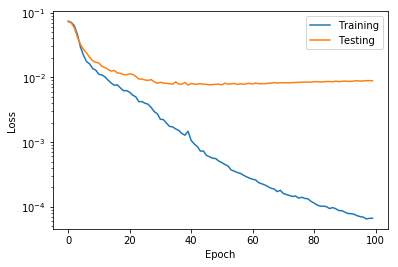

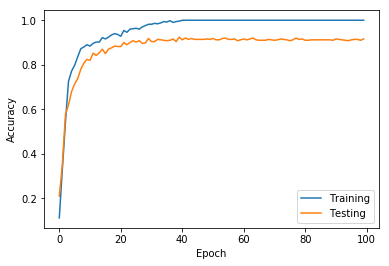

Saving models...


In [25]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_mnist.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_mnist,'raw_cnn_Smnist',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

* The accuracy and confusion matrix

The classification accuracy:  0.916



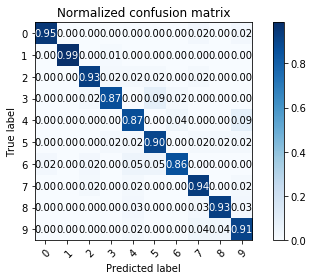

In [27]:
raw_cnn_mnist = Raw_CNN_Mnist().to(device)
load_model('raw_cnn_Smnist', raw_cnn_mnist)
y_true, y_pred = get_labels(raw_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* train the tailored CNN on MNIST

  1%|          | 1/100 [00:02<03:38,  2.20s/it]


Epoch :          0,    2203.4690 ms elapsed
loss = 0.073184     (min = 0.073184    )  	accuracy = 0.156      (max = 0.156     )
loss = 0.072238     (min = 0.072238    )  	accuracy = 0.288      (max = 0.288     )


  3%|▎         | 3/100 [00:04<02:42,  1.67s/it]


Epoch :          2,    1103.3410 ms elapsed
loss = 0.058593     (min = 0.058593    )  	accuracy = 0.62       (max = 0.62      )
loss = 0.053285     (min = 0.053285    )  	accuracy = 0.612      (max = 0.612     )


  5%|▌         | 5/100 [00:06<02:10,  1.37s/it]


Epoch :          4,    1083.9350 ms elapsed
loss = 0.027396     (min = 0.027396    )  	accuracy = 0.8        (max = 0.8       )
loss = 0.030722     (min = 0.030722    )  	accuracy = 0.69       (max = 0.69      )


  7%|▋         | 7/100 [00:08<01:48,  1.17s/it]


Epoch :          6,     937.4510 ms elapsed
loss = 0.018676     (min = 0.018676    )  	accuracy = 0.848      (max = 0.848     )
loss = 0.024917     (min = 0.024917    )  	accuracy = 0.734      (max = 0.734     )


  9%|▉         | 9/100 [00:10<01:44,  1.15s/it]


Epoch :          8,    1102.6710 ms elapsed
loss = 0.016275     (min = 0.016275    )  	accuracy = 0.838      (max = 0.848     )
loss = 0.021748     (min = 0.021748    )  	accuracy = 0.76       (max = 0.76      )


 11%|█         | 11/100 [00:12<01:35,  1.07s/it]


Epoch :         10,    1013.1300 ms elapsed
loss = 0.013983     (min = 0.013983    )  	accuracy = 0.866      (max = 0.866     )
loss = 0.020892     (min = 0.020892    )  	accuracy = 0.766      (max = 0.766     )


 13%|█▎        | 13/100 [00:14<01:29,  1.03s/it]


Epoch :         12,     932.8250 ms elapsed
loss = 0.012446     (min = 0.012446    )  	accuracy = 0.882      (max = 0.882     )
loss = 0.020562     (min = 0.019826    )  	accuracy = 0.774      (max = 0.79      )


 15%|█▌        | 15/100 [00:16<01:23,  1.02it/s]


Epoch :         14,     954.2380 ms elapsed
loss = 0.012237     (min = 0.012237    )  	accuracy = 0.884      (max = 0.884     )
loss = 0.018398     (min = 0.018398    )  	accuracy = 0.814      (max = 0.814     )


 17%|█▋        | 17/100 [00:18<01:22,  1.00it/s]


Epoch :         16,    1025.5000 ms elapsed
loss = 0.01077      (min = 0.01077     )  	accuracy = 0.898      (max = 0.908     )
loss = 0.016815     (min = 0.016815    )  	accuracy = 0.834      (max = 0.834     )


 19%|█▉        | 19/100 [00:21<01:25,  1.06s/it]


Epoch :         18,    1139.7610 ms elapsed
loss = 0.010393     (min = 0.010393    )  	accuracy = 0.89       (max = 0.908     )
loss = 0.017079     (min = 0.016815    )  	accuracy = 0.818      (max = 0.834     )


 21%|██        | 21/100 [00:23<01:25,  1.09s/it]


Epoch :         20,    1151.4130 ms elapsed
loss = 0.0089785    (min = 0.0089785   )  	accuracy = 0.916      (max = 0.916     )
loss = 0.015809     (min = 0.015809    )  	accuracy = 0.832      (max = 0.838     )


 23%|██▎       | 23/100 [00:25<01:17,  1.01s/it]


Epoch :         22,     929.6050 ms elapsed
loss = 0.0082204    (min = 0.0082204   )  	accuracy = 0.916      (max = 0.916     )
loss = 0.01511      (min = 0.01511     )  	accuracy = 0.846      (max = 0.846     )


 25%|██▌       | 25/100 [00:27<01:14,  1.00it/s]


Epoch :         24,    1007.9380 ms elapsed
loss = 0.0072354    (min = 0.0072354   )  	accuracy = 0.93       (max = 0.93      )
loss = 0.015763     (min = 0.015057    )  	accuracy = 0.828      (max = 0.846     )


 27%|██▋       | 27/100 [00:29<01:13,  1.01s/it]


Epoch :         26,    1028.1030 ms elapsed
loss = 0.0072641    (min = 0.0072354   )  	accuracy = 0.92       (max = 0.93      )
loss = 0.016211     (min = 0.014392    )  	accuracy = 0.84       (max = 0.858     )


 29%|██▉       | 29/100 [00:31<01:16,  1.07s/it]


Epoch :         28,    1138.2880 ms elapsed
loss = 0.0063397    (min = 0.0063397   )  	accuracy = 0.928      (max = 0.932     )
loss = 0.014215     (min = 0.014215    )  	accuracy = 0.856      (max = 0.858     )


 31%|███       | 31/100 [00:33<01:14,  1.08s/it]


Epoch :         30,    1009.6600 ms elapsed
loss = 0.0057532    (min = 0.0057532   )  	accuracy = 0.94       (max = 0.94      )
loss = 0.013979     (min = 0.013979    )  	accuracy = 0.868      (max = 0.868     )


 33%|███▎      | 33/100 [00:35<01:13,  1.10s/it]


Epoch :         32,    1134.1290 ms elapsed
loss = 0.0051612    (min = 0.0051612   )  	accuracy = 0.952      (max = 0.952     )
loss = 0.015822     (min = 0.013979    )  	accuracy = 0.84       (max = 0.868     )


 35%|███▌      | 35/100 [00:37<01:09,  1.07s/it]


Epoch :         34,     987.5890 ms elapsed
loss = 0.0046704    (min = 0.0046704   )  	accuracy = 0.954      (max = 0.954     )
loss = 0.015382     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 37%|███▋      | 37/100 [00:40<01:10,  1.12s/it]


Epoch :         36,    1185.2320 ms elapsed
loss = 0.0047104    (min = 0.0044944   )  	accuracy = 0.952      (max = 0.956     )
loss = 0.016608     (min = 0.013979    )  	accuracy = 0.85       (max = 0.868     )


 39%|███▉      | 39/100 [00:42<01:08,  1.13s/it]


Epoch :         38,    1140.4790 ms elapsed
loss = 0.0040304    (min = 0.0040304   )  	accuracy = 0.954      (max = 0.956     )
loss = 0.014854     (min = 0.013979    )  	accuracy = 0.854      (max = 0.868     )


 41%|████      | 41/100 [00:44<01:07,  1.14s/it]


Epoch :         40,    1254.9250 ms elapsed
loss = 0.0034796    (min = 0.0034796   )  	accuracy = 0.97       (max = 0.97      )
loss = 0.014405     (min = 0.013979    )  	accuracy = 0.866      (max = 0.868     )


 43%|████▎     | 43/100 [00:47<01:05,  1.14s/it]


Epoch :         42,    1082.4320 ms elapsed
loss = 0.0030634    (min = 0.0030634   )  	accuracy = 0.974      (max = 0.974     )
loss = 0.01787      (min = 0.013979    )  	accuracy = 0.844      (max = 0.868     )


 45%|████▌     | 45/100 [00:49<01:03,  1.16s/it]


Epoch :         44,    1193.1600 ms elapsed
loss = 0.0026628    (min = 0.0026628   )  	accuracy = 0.978      (max = 0.978     )
loss = 0.015374     (min = 0.013979    )  	accuracy = 0.856      (max = 0.868     )


 47%|████▋     | 47/100 [00:51<00:59,  1.12s/it]


Epoch :         46,    1174.4250 ms elapsed
loss = 0.0025386    (min = 0.0024857   )  	accuracy = 0.98       (max = 0.98      )
loss = 0.015818     (min = 0.013979    )  	accuracy = 0.854      (max = 0.868     )


 49%|████▉     | 49/100 [00:53<00:58,  1.16s/it]


Epoch :         48,    1163.7990 ms elapsed
loss = 0.0021964    (min = 0.0021964   )  	accuracy = 0.98       (max = 0.98      )
loss = 0.015726     (min = 0.013979    )  	accuracy = 0.864      (max = 0.868     )


 51%|█████     | 51/100 [00:56<00:53,  1.09s/it]


Epoch :         50,     968.4020 ms elapsed
loss = 0.0019691    (min = 0.0019691   )  	accuracy = 0.986      (max = 0.986     )
loss = 0.016528     (min = 0.013979    )  	accuracy = 0.86       (max = 0.868     )


 53%|█████▎    | 53/100 [00:57<00:47,  1.01s/it]


Epoch :         52,    1008.3880 ms elapsed
loss = 0.0018009    (min = 0.0018009   )  	accuracy = 0.986      (max = 0.986     )
loss = 0.015969     (min = 0.013979    )  	accuracy = 0.868      (max = 0.868     )


 55%|█████▌    | 55/100 [00:59<00:46,  1.04s/it]


Epoch :         54,    1075.8360 ms elapsed
loss = 0.0017725    (min = 0.0016726   )  	accuracy = 0.986      (max = 0.99      )
loss = 0.016493     (min = 0.013979    )  	accuracy = 0.856      (max = 0.868     )


 57%|█████▋    | 57/100 [01:02<00:45,  1.07s/it]


Epoch :         56,    1026.2680 ms elapsed
loss = 0.0013555    (min = 0.0013555   )  	accuracy = 0.992      (max = 0.992     )
loss = 0.016391     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 59%|█████▉    | 59/100 [01:04<00:42,  1.03s/it]


Epoch :         58,     982.3430 ms elapsed
loss = 0.0014644    (min = 0.0013555   )  	accuracy = 0.992      (max = 0.992     )
loss = 0.018001     (min = 0.013979    )  	accuracy = 0.862      (max = 0.868     )


 61%|██████    | 61/100 [01:06<00:40,  1.05s/it]


Epoch :         60,    1105.7770 ms elapsed
loss = 0.0011382    (min = 0.0011382   )  	accuracy = 0.99       (max = 0.996     )
loss = 0.01722      (min = 0.013979    )  	accuracy = 0.862      (max = 0.868     )


 63%|██████▎   | 63/100 [01:08<00:39,  1.08s/it]


Epoch :         62,    1098.0430 ms elapsed
loss = 0.0009607    (min = 0.0009607   )  	accuracy = 0.998      (max = 0.998     )
loss = 0.017433     (min = 0.013979    )  	accuracy = 0.856      (max = 0.868     )


 65%|██████▌   | 65/100 [01:10<00:37,  1.08s/it]


Epoch :         64,     998.6920 ms elapsed
loss = 0.0010308    (min = 0.00087611  )  	accuracy = 0.996      (max = 1         )
loss = 0.019776     (min = 0.013979    )  	accuracy = 0.85       (max = 0.868     )


 67%|██████▋   | 67/100 [01:12<00:36,  1.10s/it]


Epoch :         66,    1137.5720 ms elapsed
loss = 0.0007117    (min = 0.0007117   )  	accuracy = 1          (max = 1         )
loss = 0.01837      (min = 0.013979    )  	accuracy = 0.85       (max = 0.868     )


 69%|██████▉   | 69/100 [01:15<00:33,  1.09s/it]


Epoch :         68,    1067.0790 ms elapsed
loss = 0.00070264   (min = 0.00070264  )  	accuracy = 0.998      (max = 1         )
loss = 0.018972     (min = 0.013979    )  	accuracy = 0.86       (max = 0.868     )


 71%|███████   | 71/100 [01:17<00:29,  1.03s/it]


Epoch :         70,     962.1650 ms elapsed
loss = 0.0005728    (min = 0.0005728   )  	accuracy = 1          (max = 1         )
loss = 0.019336     (min = 0.013979    )  	accuracy = 0.854      (max = 0.868     )


 73%|███████▎  | 73/100 [01:19<00:28,  1.06s/it]


Epoch :         72,     997.0760 ms elapsed
loss = 0.00054654   (min = 0.00054654  )  	accuracy = 0.998      (max = 1         )
loss = 0.020991     (min = 0.013979    )  	accuracy = 0.85       (max = 0.868     )


 75%|███████▌  | 75/100 [01:21<00:25,  1.04s/it]


Epoch :         74,    1016.5960 ms elapsed
loss = 0.00049067   (min = 0.00049067  )  	accuracy = 1          (max = 1         )
loss = 0.020705     (min = 0.013979    )  	accuracy = 0.854      (max = 0.868     )


 77%|███████▋  | 77/100 [01:23<00:23,  1.02s/it]


Epoch :         76,    1040.5520 ms elapsed
loss = 0.00041681   (min = 0.00041681  )  	accuracy = 1          (max = 1         )
loss = 0.020276     (min = 0.013979    )  	accuracy = 0.864      (max = 0.868     )


 79%|███████▉  | 79/100 [01:25<00:21,  1.02s/it]


Epoch :         78,    1028.9190 ms elapsed
loss = 0.00043389   (min = 0.00039408  )  	accuracy = 1          (max = 1         )
loss = 0.020307     (min = 0.013979    )  	accuracy = 0.856      (max = 0.868     )


 81%|████████  | 81/100 [01:27<00:19,  1.03s/it]


Epoch :         80,    1055.7760 ms elapsed
loss = 0.00036983   (min = 0.00036341  )  	accuracy = 1          (max = 1         )
loss = 0.020692     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 83%|████████▎ | 83/100 [01:29<00:17,  1.05s/it]


Epoch :         82,    1023.1830 ms elapsed
loss = 0.00036011   (min = 0.00035205  )  	accuracy = 1          (max = 1         )
loss = 0.022321     (min = 0.013979    )  	accuracy = 0.86       (max = 0.868     )


 85%|████████▌ | 85/100 [01:31<00:14,  1.02it/s]


Epoch :         84,     805.9450 ms elapsed
loss = 0.00030083   (min = 0.00030083  )  	accuracy = 1          (max = 1         )
loss = 0.021554     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 87%|████████▋ | 87/100 [01:33<00:13,  1.05s/it]


Epoch :         86,    1126.3620 ms elapsed
loss = 0.00030613   (min = 0.00030083  )  	accuracy = 1          (max = 1         )
loss = 0.022227     (min = 0.013979    )  	accuracy = 0.864      (max = 0.868     )


 89%|████████▉ | 89/100 [01:35<00:10,  1.01it/s]


Epoch :         88,    1009.7390 ms elapsed
loss = 0.00031485   (min = 0.00030083  )  	accuracy = 1          (max = 1         )
loss = 0.021996     (min = 0.013979    )  	accuracy = 0.862      (max = 0.868     )


 91%|█████████ | 91/100 [01:37<00:09,  1.00s/it]


Epoch :         90,     945.0300 ms elapsed
loss = 0.00026972   (min = 0.00026474  )  	accuracy = 1          (max = 1         )
loss = 0.022279     (min = 0.013979    )  	accuracy = 0.854      (max = 0.868     )


 93%|█████████▎| 93/100 [01:39<00:06,  1.01it/s]


Epoch :         92,    1009.7760 ms elapsed
loss = 0.00024254   (min = 0.0002407   )  	accuracy = 1          (max = 1         )
loss = 0.022426     (min = 0.013979    )  	accuracy = 0.86       (max = 0.868     )


 95%|█████████▌| 95/100 [01:41<00:05,  1.03s/it]


Epoch :         94,    1046.1200 ms elapsed
loss = 0.00021911   (min = 0.00021911  )  	accuracy = 1          (max = 1         )
loss = 0.022944     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 97%|█████████▋| 97/100 [01:43<00:03,  1.03s/it]


Epoch :         96,     972.4300 ms elapsed
loss = 0.00019393   (min = 0.00019393  )  	accuracy = 1          (max = 1         )
loss = 0.022943     (min = 0.013979    )  	accuracy = 0.858      (max = 0.868     )


 99%|█████████▉| 99/100 [01:45<00:00,  1.01it/s]


Epoch :         98,     920.2200 ms elapsed
loss = 0.00017579   (min = 0.00017579  )  	accuracy = 1          (max = 1         )
loss = 0.022999     (min = 0.013979    )  	accuracy = 0.862      (max = 0.868     )


100%|██████████| 100/100 [01:46<00:00,  1.04s/it]


Finished Training


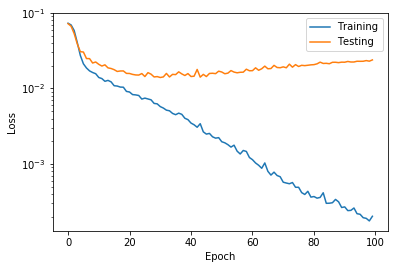

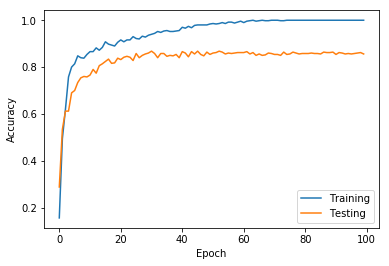

Saving models...


In [8]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_mnist.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_mnist,'tailor_cnn_Smnist', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH)

* The accuracy and confusion matrix of tailored CNN

The classification accuracy:  0.856



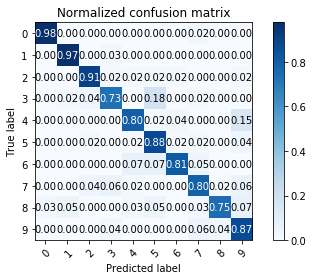

In [9]:
tailored_cnn_mnist = Tailored_CNN_Mnist().to(device)
load_model('tailor_cnn_Smnist', tailored_cnn_mnist)
y_true, y_pred = get_labels(tailored_cnn_mnist, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### experiment FashionMnist

In [10]:
# trainset_cnn = FashionMNIST(root='./data', train=True, transform=transforms.Compose([
#             transforms.ToTensor()]))

# trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=NUM_WORKERS)

# testset_cnn = FashionMNIST(root='./data', train=False, transform=transforms.Compose([
#             transforms.ToTensor()]))

# testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
#                                          shuffle=False, num_workers=NUM_WORKERS)

In [10]:
class FashionMNIST500(Dataset):
    def __init__(self, datasetPath, train=False):
        self.path = datasetPath
        ds = FashionMNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
            transforms.ToTensor()]))
        self.samples = [ds[i] for i in range(0, 500)]

    def __getitem__(self, index):
        x, y = self.samples[index]
        return x, y

    def __len__(self):
        return len(self.samples)

In [11]:
trainset_cnn = FashionMNIST500('./data', train=True)

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cnn = FashionMNIST500('./data', train=False)

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

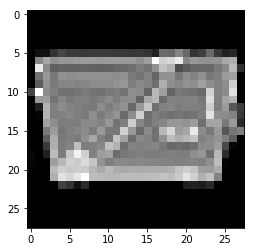

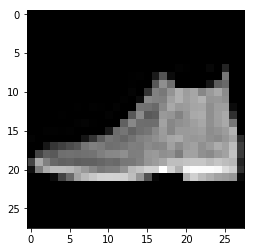

In [19]:
# check if we choose the correct dataset
plt.imshow(next(iter(trainloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

plt.imshow(next(iter(testloader_cnn))[0][0].squeeze(), cmap='gray')
plt.show()

  1%|          | 1/120 [00:01<02:11,  1.10s/it]


Epoch :          0,    1103.2700 ms elapsed
loss = 0.072808     (min = 0.072808    )  	accuracy = 0.12       (max = 0.12      )
loss = 0.071112     (min = 0.071112    )  	accuracy = 0.284      (max = 0.284     )


  2%|▎         | 3/120 [00:03<02:03,  1.05s/it]


Epoch :          2,     960.3160 ms elapsed
loss = 0.057664     (min = 0.057664    )  	accuracy = 0.39       (max = 0.39      )
loss = 0.047963     (min = 0.047963    )  	accuracy = 0.58       (max = 0.58      )


  4%|▍         | 5/120 [00:05<02:01,  1.05s/it]


Epoch :          4,    1122.5360 ms elapsed
loss = 0.034308     (min = 0.034308    )  	accuracy = 0.622      (max = 0.622     )
loss = 0.035151     (min = 0.035151    )  	accuracy = 0.618      (max = 0.618     )


  6%|▌         | 7/120 [00:07<01:56,  1.03s/it]


Epoch :          6,    1033.9650 ms elapsed
loss = 0.029879     (min = 0.029879    )  	accuracy = 0.676      (max = 0.676     )
loss = 0.028491     (min = 0.028491    )  	accuracy = 0.666      (max = 0.666     )


  8%|▊         | 9/120 [00:09<01:55,  1.04s/it]


Epoch :          8,     967.7200 ms elapsed
loss = 0.025393     (min = 0.025393    )  	accuracy = 0.738      (max = 0.738     )
loss = 0.026348     (min = 0.026348    )  	accuracy = 0.686      (max = 0.69      )


  9%|▉         | 11/120 [00:11<01:49,  1.00s/it]


Epoch :         10,     973.7910 ms elapsed
loss = 0.023682     (min = 0.023682    )  	accuracy = 0.74       (max = 0.74      )
loss = 0.026414     (min = 0.025086    )  	accuracy = 0.65       (max = 0.69      )


 11%|█         | 13/120 [00:13<01:55,  1.08s/it]


Epoch :         12,    1204.2450 ms elapsed
loss = 0.02148      (min = 0.02148     )  	accuracy = 0.77       (max = 0.77      )
loss = 0.023615     (min = 0.023615    )  	accuracy = 0.73       (max = 0.73      )


 12%|█▎        | 15/120 [00:15<01:53,  1.08s/it]


Epoch :         14,    1108.9460 ms elapsed
loss = 0.020956     (min = 0.020892    )  	accuracy = 0.78       (max = 0.786     )
loss = 0.023072     (min = 0.022821    )  	accuracy = 0.736      (max = 0.736     )


 14%|█▍        | 17/120 [00:17<01:39,  1.04it/s]


Epoch :         16,     696.6010 ms elapsed
loss = 0.019422     (min = 0.019422    )  	accuracy = 0.788      (max = 0.788     )
loss = 0.021418     (min = 0.021418    )  	accuracy = 0.738      (max = 0.738     )


 16%|█▌        | 19/120 [00:18<01:23,  1.22it/s]


Epoch :         18,     724.6690 ms elapsed
loss = 0.018738     (min = 0.018738    )  	accuracy = 0.784      (max = 0.788     )
loss = 0.021235     (min = 0.021235    )  	accuracy = 0.74       (max = 0.742     )


 18%|█▊        | 21/120 [00:20<01:18,  1.27it/s]


Epoch :         20,     738.0630 ms elapsed
loss = 0.018242     (min = 0.018242    )  	accuracy = 0.82       (max = 0.82      )
loss = 0.020668     (min = 0.020668    )  	accuracy = 0.748      (max = 0.748     )


 19%|█▉        | 23/120 [00:22<01:20,  1.20it/s]


Epoch :         22,     896.8320 ms elapsed
loss = 0.017294     (min = 0.017294    )  	accuracy = 0.816      (max = 0.82      )
loss = 0.020392     (min = 0.020392    )  	accuracy = 0.75       (max = 0.75      )


 21%|██        | 25/120 [00:23<01:24,  1.12it/s]


Epoch :         24,     969.2110 ms elapsed
loss = 0.017354     (min = 0.01693     )  	accuracy = 0.802      (max = 0.822     )
loss = 0.019963     (min = 0.019963    )  	accuracy = 0.754      (max = 0.754     )


 22%|██▎       | 27/120 [00:26<01:34,  1.02s/it]


Epoch :         26,    1142.0670 ms elapsed
loss = 0.016029     (min = 0.016029    )  	accuracy = 0.834      (max = 0.834     )
loss = 0.019616     (min = 0.019616    )  	accuracy = 0.756      (max = 0.758     )


 24%|██▍       | 29/120 [00:28<01:37,  1.07s/it]


Epoch :         28,    1031.2580 ms elapsed
loss = 0.016751     (min = 0.015989    )  	accuracy = 0.814      (max = 0.834     )
loss = 0.019768     (min = 0.019616    )  	accuracy = 0.764      (max = 0.764     )


 26%|██▌       | 31/120 [00:30<01:38,  1.11s/it]


Epoch :         30,    1117.3080 ms elapsed
loss = 0.016494     (min = 0.015989    )  	accuracy = 0.83       (max = 0.834     )
loss = 0.019048     (min = 0.019048    )  	accuracy = 0.762      (max = 0.764     )


 28%|██▊       | 33/120 [00:32<01:34,  1.08s/it]


Epoch :         32,    1002.9550 ms elapsed
loss = 0.015119     (min = 0.015119    )  	accuracy = 0.836      (max = 0.836     )
loss = 0.020199     (min = 0.019048    )  	accuracy = 0.746      (max = 0.772     )


 29%|██▉       | 35/120 [00:35<01:32,  1.08s/it]


Epoch :         34,    1122.9410 ms elapsed
loss = 0.014319     (min = 0.014319    )  	accuracy = 0.838      (max = 0.84      )
loss = 0.022498     (min = 0.019048    )  	accuracy = 0.712      (max = 0.772     )


 31%|███       | 37/120 [00:37<01:36,  1.16s/it]


Epoch :         36,    1329.0250 ms elapsed
loss = 0.013939     (min = 0.013939    )  	accuracy = 0.842      (max = 0.842     )
loss = 0.018869     (min = 0.018869    )  	accuracy = 0.772      (max = 0.772     )


 32%|███▎      | 39/120 [00:39<01:29,  1.10s/it]


Epoch :         38,    1043.2450 ms elapsed
loss = 0.013294     (min = 0.013294    )  	accuracy = 0.86       (max = 0.86      )
loss = 0.020139     (min = 0.018869    )  	accuracy = 0.746      (max = 0.772     )


 34%|███▍      | 41/120 [00:41<01:23,  1.06s/it]


Epoch :         40,     959.1610 ms elapsed
loss = 0.013615     (min = 0.013294    )  	accuracy = 0.836      (max = 0.86      )
loss = 0.018905     (min = 0.018869    )  	accuracy = 0.774      (max = 0.774     )


 36%|███▌      | 43/120 [00:43<01:21,  1.06s/it]


Epoch :         42,    1123.4430 ms elapsed
loss = 0.013467     (min = 0.012929    )  	accuracy = 0.842      (max = 0.862     )
loss = 0.021546     (min = 0.018869    )  	accuracy = 0.72       (max = 0.774     )


 38%|███▊      | 45/120 [00:46<01:21,  1.09s/it]


Epoch :         44,    1159.4550 ms elapsed
loss = 0.012376     (min = 0.011932    )  	accuracy = 0.858      (max = 0.866     )
loss = 0.019635     (min = 0.018617    )  	accuracy = 0.77       (max = 0.782     )


 39%|███▉      | 47/120 [00:48<01:18,  1.08s/it]


Epoch :         46,    1026.1890 ms elapsed
loss = 0.011451     (min = 0.011451    )  	accuracy = 0.876      (max = 0.876     )
loss = 0.019174     (min = 0.018617    )  	accuracy = 0.768      (max = 0.786     )


 41%|████      | 49/120 [00:50<01:17,  1.08s/it]


Epoch :         48,    1076.9200 ms elapsed
loss = 0.012352     (min = 0.011451    )  	accuracy = 0.854      (max = 0.876     )
loss = 0.01871      (min = 0.018617    )  	accuracy = 0.796      (max = 0.796     )


 42%|████▎     | 51/120 [00:52<01:21,  1.18s/it]


Epoch :         50,    1374.1730 ms elapsed
loss = 0.011137     (min = 0.011137    )  	accuracy = 0.862      (max = 0.876     )
loss = 0.018754     (min = 0.018617    )  	accuracy = 0.786      (max = 0.796     )


 44%|████▍     | 53/120 [00:55<01:22,  1.23s/it]


Epoch :         52,    1227.8130 ms elapsed
loss = 0.010881     (min = 0.010881    )  	accuracy = 0.884      (max = 0.884     )
loss = 0.02004      (min = 0.018617    )  	accuracy = 0.756      (max = 0.796     )


 46%|████▌     | 55/120 [00:57<01:17,  1.18s/it]


Epoch :         54,    1078.1790 ms elapsed
loss = 0.010062     (min = 0.010062    )  	accuracy = 0.898      (max = 0.898     )
loss = 0.019491     (min = 0.018617    )  	accuracy = 0.792      (max = 0.796     )


 48%|████▊     | 57/120 [01:00<01:12,  1.15s/it]


Epoch :         56,    1122.9980 ms elapsed
loss = 0.010663     (min = 0.010062    )  	accuracy = 0.876      (max = 0.898     )
loss = 0.019746     (min = 0.018617    )  	accuracy = 0.764      (max = 0.796     )


 49%|████▉     | 59/120 [01:02<01:11,  1.18s/it]


Epoch :         58,    1204.9260 ms elapsed
loss = 0.0095277    (min = 0.0095277   )  	accuracy = 0.904      (max = 0.904     )
loss = 0.018759     (min = 0.018617    )  	accuracy = 0.792      (max = 0.796     )


 51%|█████     | 61/120 [01:04<01:09,  1.18s/it]


Epoch :         60,    1114.8410 ms elapsed
loss = 0.0091529    (min = 0.0091205   )  	accuracy = 0.914      (max = 0.914     )
loss = 0.020318     (min = 0.018617    )  	accuracy = 0.758      (max = 0.796     )


 52%|█████▎    | 63/120 [01:07<01:09,  1.22s/it]


Epoch :         62,    1304.9850 ms elapsed
loss = 0.0091286    (min = 0.0091205   )  	accuracy = 0.904      (max = 0.914     )
loss = 0.019259     (min = 0.018617    )  	accuracy = 0.788      (max = 0.796     )


 54%|█████▍    | 65/120 [01:09<01:08,  1.25s/it]


Epoch :         64,    1214.8730 ms elapsed
loss = 0.0090316    (min = 0.0090316   )  	accuracy = 0.92       (max = 0.92      )
loss = 0.019769     (min = 0.018617    )  	accuracy = 0.788      (max = 0.802     )


 56%|█████▌    | 67/120 [01:12<01:05,  1.24s/it]


Epoch :         66,    1276.2160 ms elapsed
loss = 0.0087394    (min = 0.0087394   )  	accuracy = 0.914      (max = 0.92      )
loss = 0.01964      (min = 0.018617    )  	accuracy = 0.77       (max = 0.802     )


 57%|█████▊    | 69/120 [01:15<01:07,  1.31s/it]


Epoch :         68,    1417.6350 ms elapsed
loss = 0.011192     (min = 0.0087394   )  	accuracy = 0.862      (max = 0.92      )
loss = 0.026332     (min = 0.018617    )  	accuracy = 0.724      (max = 0.802     )


 59%|█████▉    | 71/120 [01:17<01:01,  1.25s/it]


Epoch :         70,    1192.3110 ms elapsed
loss = 0.0091439    (min = 0.0087394   )  	accuracy = 0.912      (max = 0.92      )
loss = 0.018969     (min = 0.018617    )  	accuracy = 0.792      (max = 0.802     )


 61%|██████    | 73/120 [01:19<00:56,  1.21s/it]


Epoch :         72,    1150.7600 ms elapsed
loss = 0.0079252    (min = 0.0079252   )  	accuracy = 0.92       (max = 0.92      )
loss = 0.019226     (min = 0.018617    )  	accuracy = 0.794      (max = 0.802     )


 62%|██████▎   | 75/120 [01:22<00:55,  1.24s/it]


Epoch :         74,    1225.0130 ms elapsed
loss = 0.0075859    (min = 0.0075859   )  	accuracy = 0.918      (max = 0.938     )
loss = 0.020915     (min = 0.018617    )  	accuracy = 0.778      (max = 0.802     )


 64%|██████▍   | 77/120 [01:24<00:55,  1.29s/it]


Epoch :         76,    1401.4510 ms elapsed
loss = 0.0074698    (min = 0.0074698   )  	accuracy = 0.926      (max = 0.938     )
loss = 0.01956      (min = 0.018617    )  	accuracy = 0.804      (max = 0.804     )


 66%|██████▌   | 79/120 [01:27<00:53,  1.29s/it]


Epoch :         78,    1351.9460 ms elapsed
loss = 0.0074915    (min = 0.0074698   )  	accuracy = 0.924      (max = 0.938     )
loss = 0.020373     (min = 0.018617    )  	accuracy = 0.79       (max = 0.804     )


 68%|██████▊   | 81/120 [01:30<00:51,  1.33s/it]


Epoch :         80,    1436.2580 ms elapsed
loss = 0.0072967    (min = 0.0072967   )  	accuracy = 0.922      (max = 0.938     )
loss = 0.020801     (min = 0.018617    )  	accuracy = 0.78       (max = 0.804     )


 69%|██████▉   | 83/120 [01:32<00:49,  1.34s/it]


Epoch :         82,    1391.1560 ms elapsed
loss = 0.0077549    (min = 0.0069401   )  	accuracy = 0.908      (max = 0.938     )
loss = 0.020424     (min = 0.018617    )  	accuracy = 0.79       (max = 0.804     )


 71%|███████   | 85/120 [01:35<00:45,  1.31s/it]


Epoch :         84,    1278.2530 ms elapsed
loss = 0.006554     (min = 0.0064445   )  	accuracy = 0.936      (max = 0.938     )
loss = 0.020147     (min = 0.018617    )  	accuracy = 0.802      (max = 0.804     )


 72%|███████▎  | 87/120 [01:37<00:41,  1.26s/it]


Epoch :         86,    1251.3160 ms elapsed
loss = 0.0062066    (min = 0.0062066   )  	accuracy = 0.94       (max = 0.94      )
loss = 0.021025     (min = 0.018617    )  	accuracy = 0.778      (max = 0.804     )


 74%|███████▍  | 89/120 [01:40<00:37,  1.20s/it]


Epoch :         88,    1187.2860 ms elapsed
loss = 0.0063736    (min = 0.0058872   )  	accuracy = 0.936      (max = 0.948     )
loss = 0.021068     (min = 0.018617    )  	accuracy = 0.792      (max = 0.804     )


 76%|███████▌  | 91/120 [01:42<00:34,  1.21s/it]


Epoch :         90,    1202.9830 ms elapsed
loss = 0.0067986    (min = 0.0058872   )  	accuracy = 0.934      (max = 0.948     )
loss = 0.022087     (min = 0.018617    )  	accuracy = 0.782      (max = 0.806     )


 78%|███████▊  | 93/120 [01:45<00:34,  1.26s/it]


Epoch :         92,    1285.4830 ms elapsed
loss = 0.005967     (min = 0.0058872   )  	accuracy = 0.934      (max = 0.948     )
loss = 0.020656     (min = 0.018617    )  	accuracy = 0.796      (max = 0.806     )


 79%|███████▉  | 95/120 [01:47<00:30,  1.22s/it]


Epoch :         94,    1168.8090 ms elapsed
loss = 0.005291     (min = 0.005291    )  	accuracy = 0.954      (max = 0.954     )
loss = 0.022207     (min = 0.018617    )  	accuracy = 0.77       (max = 0.806     )


 81%|████████  | 97/120 [01:49<00:26,  1.16s/it]


Epoch :         96,    1092.2440 ms elapsed
loss = 0.0052933    (min = 0.005291    )  	accuracy = 0.948      (max = 0.954     )
loss = 0.021057     (min = 0.018617    )  	accuracy = 0.798      (max = 0.806     )


 82%|████████▎ | 99/120 [01:52<00:23,  1.14s/it]


Epoch :         98,    1094.6500 ms elapsed
loss = 0.0055127    (min = 0.005291    )  	accuracy = 0.942      (max = 0.954     )
loss = 0.022348     (min = 0.018617    )  	accuracy = 0.786      (max = 0.806     )


 84%|████████▍ | 101/120 [01:54<00:20,  1.09s/it]


Epoch :        100,    1001.7070 ms elapsed
loss = 0.0050907    (min = 0.0047293   )  	accuracy = 0.946      (max = 0.962     )
loss = 0.021307     (min = 0.018617    )  	accuracy = 0.796      (max = 0.806     )


 86%|████████▌ | 103/120 [01:56<00:19,  1.12s/it]


Epoch :        102,    1146.9250 ms elapsed
loss = 0.0053313    (min = 0.0046735   )  	accuracy = 0.942      (max = 0.962     )
loss = 0.021512     (min = 0.018617    )  	accuracy = 0.808      (max = 0.808     )


 88%|████████▊ | 105/120 [01:58<00:17,  1.18s/it]


Epoch :        104,    1239.5550 ms elapsed
loss = 0.0046736    (min = 0.0044271   )  	accuracy = 0.968      (max = 0.968     )
loss = 0.022461     (min = 0.018617    )  	accuracy = 0.788      (max = 0.808     )


 89%|████████▉ | 107/120 [02:01<00:14,  1.15s/it]


Epoch :        106,    1140.2560 ms elapsed
loss = 0.0045921    (min = 0.0044271   )  	accuracy = 0.96       (max = 0.968     )
loss = 0.022964     (min = 0.018617    )  	accuracy = 0.766      (max = 0.808     )


 91%|█████████ | 109/120 [02:03<00:12,  1.15s/it]


Epoch :        108,    1121.4240 ms elapsed
loss = 0.0039063    (min = 0.0039063   )  	accuracy = 0.966      (max = 0.968     )
loss = 0.023414     (min = 0.018617    )  	accuracy = 0.782      (max = 0.808     )


 92%|█████████▎| 111/120 [02:05<00:09,  1.10s/it]


Epoch :        110,     982.1940 ms elapsed
loss = 0.0036165    (min = 0.0036165   )  	accuracy = 0.978      (max = 0.978     )
loss = 0.024824     (min = 0.018617    )  	accuracy = 0.776      (max = 0.808     )


 94%|█████████▍| 113/120 [02:07<00:07,  1.04s/it]


Epoch :        112,     903.6840 ms elapsed
loss = 0.0052646    (min = 0.0036165   )  	accuracy = 0.952      (max = 0.978     )
loss = 0.023098     (min = 0.018617    )  	accuracy = 0.798      (max = 0.808     )


 96%|█████████▌| 115/120 [02:09<00:05,  1.10s/it]


Epoch :        114,    1165.0330 ms elapsed
loss = 0.0051315    (min = 0.0036165   )  	accuracy = 0.948      (max = 0.978     )
loss = 0.02526      (min = 0.018617    )  	accuracy = 0.764      (max = 0.808     )


 98%|█████████▊| 117/120 [02:12<00:03,  1.15s/it]


Epoch :        116,    1196.7810 ms elapsed
loss = 0.0036764    (min = 0.0036165   )  	accuracy = 0.972      (max = 0.978     )
loss = 0.022806     (min = 0.018617    )  	accuracy = 0.794      (max = 0.808     )


 99%|█████████▉| 119/120 [02:14<00:01,  1.16s/it]


Epoch :        118,    1263.6870 ms elapsed
loss = 0.0033546    (min = 0.0033546   )  	accuracy = 0.98       (max = 0.98      )
loss = 0.023489     (min = 0.018617    )  	accuracy = 0.784      (max = 0.808     )


100%|██████████| 120/120 [02:15<00:00,  1.18s/it]


Finished Training


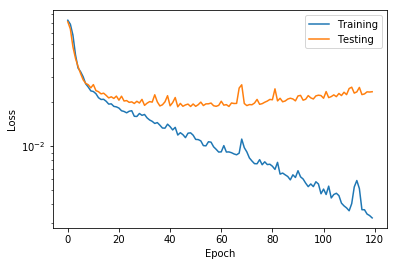

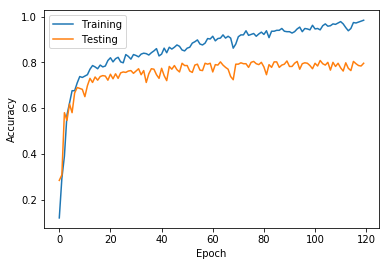

Saving models...


In [12]:
# use the same network structure as for mninst task
raw_cnn_fashion = Raw_CNN_Mnist().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_fashion.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_fashion,'raw_cnn_Sfashion',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH+20)

The classification accuracy:  0.796



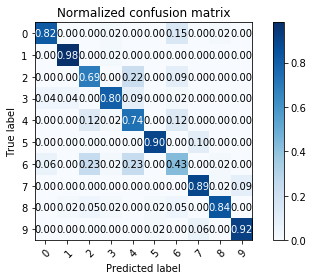

In [13]:
raw_cnn_fashion = Raw_CNN_Mnist().to(device)
load_model('raw_cnn_Sfashion', raw_cnn_fashion)
y_true, y_pred = get_labels(raw_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

  1%|          | 1/120 [00:00<01:49,  1.09it/s]


Epoch :          0,     919.5990 ms elapsed
loss = 0.073345     (min = 0.073345    )  	accuracy = 0.184      (max = 0.184     )
loss = 0.07234      (min = 0.07234     )  	accuracy = 0.298      (max = 0.298     )


  2%|▎         | 3/120 [00:03<02:00,  1.03s/it]


Epoch :          2,    1122.6800 ms elapsed
loss = 0.058029     (min = 0.058029    )  	accuracy = 0.444      (max = 0.444     )
loss = 0.04726      (min = 0.04726     )  	accuracy = 0.576      (max = 0.576     )


  4%|▍         | 5/120 [00:05<02:01,  1.06s/it]


Epoch :          4,    1061.0480 ms elapsed
loss = 0.033879     (min = 0.033879    )  	accuracy = 0.596      (max = 0.596     )
loss = 0.031919     (min = 0.031919    )  	accuracy = 0.662      (max = 0.662     )


  6%|▌         | 7/120 [00:07<01:55,  1.02s/it]


Epoch :          6,     997.5450 ms elapsed
loss = 0.028577     (min = 0.028577    )  	accuracy = 0.692      (max = 0.692     )
loss = 0.02787      (min = 0.02787     )  	accuracy = 0.69       (max = 0.692     )


  8%|▊         | 9/120 [00:09<01:59,  1.07s/it]


Epoch :          8,    1174.3100 ms elapsed
loss = 0.026506     (min = 0.026506    )  	accuracy = 0.72       (max = 0.72      )
loss = 0.027354     (min = 0.027354    )  	accuracy = 0.65       (max = 0.692     )


  9%|▉         | 11/120 [00:11<01:54,  1.05s/it]


Epoch :         10,     961.4770 ms elapsed
loss = 0.024965     (min = 0.024965    )  	accuracy = 0.726      (max = 0.726     )
loss = 0.025079     (min = 0.025079    )  	accuracy = 0.69       (max = 0.692     )


 11%|█         | 13/120 [00:13<01:48,  1.02s/it]


Epoch :         12,     941.5110 ms elapsed
loss = 0.024485     (min = 0.024485    )  	accuracy = 0.722      (max = 0.726     )
loss = 0.024283     (min = 0.024283    )  	accuracy = 0.706      (max = 0.718     )


 12%|█▎        | 15/120 [00:15<01:51,  1.06s/it]


Epoch :         14,    1068.6960 ms elapsed
loss = 0.022459     (min = 0.022459    )  	accuracy = 0.75       (max = 0.764     )
loss = 0.025819     (min = 0.024283    )  	accuracy = 0.668      (max = 0.718     )


 14%|█▍        | 17/120 [00:18<01:50,  1.07s/it]


Epoch :         16,    1059.3290 ms elapsed
loss = 0.021785     (min = 0.021785    )  	accuracy = 0.754      (max = 0.764     )
loss = 0.02329      (min = 0.02329     )  	accuracy = 0.708      (max = 0.718     )


 16%|█▌        | 19/120 [00:20<01:47,  1.06s/it]


Epoch :         18,    1048.1750 ms elapsed
loss = 0.02058      (min = 0.02058     )  	accuracy = 0.762      (max = 0.78      )
loss = 0.022924     (min = 0.022924    )  	accuracy = 0.716      (max = 0.718     )


 18%|█▊        | 21/120 [00:22<01:43,  1.05s/it]


Epoch :         20,    1014.8990 ms elapsed
loss = 0.020736     (min = 0.02058     )  	accuracy = 0.766      (max = 0.78      )
loss = 0.029369     (min = 0.022924    )  	accuracy = 0.666      (max = 0.718     )


 19%|█▉        | 23/120 [00:24<01:42,  1.06s/it]


Epoch :         22,    1077.1210 ms elapsed
loss = 0.020132     (min = 0.020132    )  	accuracy = 0.772      (max = 0.78      )
loss = 0.021798     (min = 0.021798    )  	accuracy = 0.724      (max = 0.724     )


 21%|██        | 25/120 [00:26<01:40,  1.06s/it]


Epoch :         24,    1048.3540 ms elapsed
loss = 0.019445     (min = 0.019172    )  	accuracy = 0.804      (max = 0.804     )
loss = 0.022694     (min = 0.021798    )  	accuracy = 0.71       (max = 0.742     )


 22%|██▎       | 27/120 [00:28<01:38,  1.06s/it]


Epoch :         26,    1039.4010 ms elapsed
loss = 0.018505     (min = 0.018505    )  	accuracy = 0.806      (max = 0.806     )
loss = 0.026305     (min = 0.021798    )  	accuracy = 0.688      (max = 0.742     )


 24%|██▍       | 29/120 [00:30<01:30,  1.01it/s]


Epoch :         28,     864.1670 ms elapsed
loss = 0.018705     (min = 0.018505    )  	accuracy = 0.796      (max = 0.806     )
loss = 0.022027     (min = 0.021798    )  	accuracy = 0.726      (max = 0.742     )


 26%|██▌       | 31/120 [00:32<01:25,  1.04it/s]


Epoch :         30,     907.0440 ms elapsed
loss = 0.017934     (min = 0.017934    )  	accuracy = 0.794      (max = 0.806     )
loss = 0.022642     (min = 0.021356    )  	accuracy = 0.718      (max = 0.742     )


 28%|██▊       | 33/120 [00:34<01:27,  1.01s/it]


Epoch :         32,    1121.9560 ms elapsed
loss = 0.017543     (min = 0.017543    )  	accuracy = 0.808      (max = 0.808     )
loss = 0.022377     (min = 0.021356    )  	accuracy = 0.706      (max = 0.742     )


 29%|██▉       | 35/120 [00:36<01:25,  1.01s/it]


Epoch :         34,    1077.5070 ms elapsed
loss = 0.017366     (min = 0.017167    )  	accuracy = 0.798      (max = 0.82      )
loss = 0.024695     (min = 0.021356    )  	accuracy = 0.706      (max = 0.742     )


 31%|███       | 37/120 [00:38<01:28,  1.06s/it]


Epoch :         36,    1160.1560 ms elapsed
loss = 0.017079     (min = 0.017079    )  	accuracy = 0.804      (max = 0.82      )
loss = 0.021245     (min = 0.021245    )  	accuracy = 0.746      (max = 0.746     )


 32%|███▎      | 39/120 [00:40<01:24,  1.05s/it]


Epoch :         38,    1032.3070 ms elapsed
loss = 0.016489     (min = 0.016489    )  	accuracy = 0.822      (max = 0.822     )
loss = 0.020884     (min = 0.020884    )  	accuracy = 0.736      (max = 0.746     )


 34%|███▍      | 41/120 [00:42<01:26,  1.10s/it]


Epoch :         40,    1205.1600 ms elapsed
loss = 0.016333     (min = 0.016333    )  	accuracy = 0.808      (max = 0.822     )
loss = 0.022095     (min = 0.020884    )  	accuracy = 0.714      (max = 0.746     )


 36%|███▌      | 43/120 [00:45<01:25,  1.11s/it]


Epoch :         42,    1127.7040 ms elapsed
loss = 0.015803     (min = 0.015803    )  	accuracy = 0.824      (max = 0.824     )
loss = 0.021668     (min = 0.020884    )  	accuracy = 0.738      (max = 0.746     )


 38%|███▊      | 45/120 [00:47<01:21,  1.08s/it]


Epoch :         44,    1044.8990 ms elapsed
loss = 0.015283     (min = 0.015283    )  	accuracy = 0.836      (max = 0.836     )
loss = 0.0207       (min = 0.020661    )  	accuracy = 0.734      (max = 0.746     )


 39%|███▉      | 47/120 [00:49<01:15,  1.04s/it]


Epoch :         46,    1095.4410 ms elapsed
loss = 0.014916     (min = 0.014916    )  	accuracy = 0.846      (max = 0.846     )
loss = 0.022187     (min = 0.020661    )  	accuracy = 0.72       (max = 0.746     )


 41%|████      | 49/120 [00:51<01:16,  1.07s/it]


Epoch :         48,    1157.6810 ms elapsed
loss = 0.014819     (min = 0.014819    )  	accuracy = 0.83       (max = 0.846     )
loss = 0.023871     (min = 0.020661    )  	accuracy = 0.708      (max = 0.746     )


 42%|████▎     | 51/120 [00:53<01:14,  1.08s/it]


Epoch :         50,    1112.2910 ms elapsed
loss = 0.014805     (min = 0.014805    )  	accuracy = 0.85       (max = 0.85      )
loss = 0.02198      (min = 0.020661    )  	accuracy = 0.724      (max = 0.746     )


 44%|████▍     | 53/120 [00:55<01:10,  1.04s/it]


Epoch :         52,    1018.3890 ms elapsed
loss = 0.014807     (min = 0.014805    )  	accuracy = 0.834      (max = 0.852     )
loss = 0.022755     (min = 0.020661    )  	accuracy = 0.73       (max = 0.752     )


 46%|████▌     | 55/120 [00:57<01:11,  1.10s/it]


Epoch :         54,    1219.1910 ms elapsed
loss = 0.014013     (min = 0.014013    )  	accuracy = 0.844      (max = 0.852     )
loss = 0.021231     (min = 0.020661    )  	accuracy = 0.728      (max = 0.758     )


 48%|████▊     | 57/120 [01:00<01:09,  1.10s/it]


Epoch :         56,    1038.4640 ms elapsed
loss = 0.013479     (min = 0.013479    )  	accuracy = 0.846      (max = 0.854     )
loss = 0.020865     (min = 0.020661    )  	accuracy = 0.758      (max = 0.758     )


 49%|████▉     | 59/120 [01:01<01:01,  1.00s/it]


Epoch :         58,     837.7050 ms elapsed
loss = 0.013663     (min = 0.013273    )  	accuracy = 0.858      (max = 0.87      )
loss = 0.022043     (min = 0.020661    )  	accuracy = 0.728      (max = 0.758     )


 51%|█████     | 61/120 [01:03<00:49,  1.19it/s]


Epoch :         60,     651.5400 ms elapsed
loss = 0.013114     (min = 0.013114    )  	accuracy = 0.86       (max = 0.87      )
loss = 0.021204     (min = 0.020661    )  	accuracy = 0.756      (max = 0.758     )


 52%|█████▎    | 63/120 [01:04<00:44,  1.27it/s]


Epoch :         62,     748.7490 ms elapsed
loss = 0.012384     (min = 0.012384    )  	accuracy = 0.876      (max = 0.876     )
loss = 0.021368     (min = 0.020661    )  	accuracy = 0.756      (max = 0.758     )


 54%|█████▍    | 65/120 [01:06<00:41,  1.33it/s]


Epoch :         64,     713.6890 ms elapsed
loss = 0.013776     (min = 0.012384    )  	accuracy = 0.852      (max = 0.876     )
loss = 0.021651     (min = 0.020661    )  	accuracy = 0.748      (max = 0.758     )


 56%|█████▌    | 67/120 [01:07<00:41,  1.29it/s]


Epoch :         66,     796.4530 ms elapsed
loss = 0.012862     (min = 0.012372    )  	accuracy = 0.858      (max = 0.876     )
loss = 0.02151      (min = 0.020661    )  	accuracy = 0.762      (max = 0.762     )


 57%|█████▊    | 69/120 [01:09<00:46,  1.10it/s]


Epoch :         68,     994.5400 ms elapsed
loss = 0.012695     (min = 0.012372    )  	accuracy = 0.856      (max = 0.876     )
loss = 0.02366      (min = 0.020661    )  	accuracy = 0.75       (max = 0.762     )


 59%|█████▉    | 71/120 [01:11<00:46,  1.06it/s]


Epoch :         70,     927.8270 ms elapsed
loss = 0.012499     (min = 0.012372    )  	accuracy = 0.856      (max = 0.876     )
loss = 0.020939     (min = 0.020661    )  	accuracy = 0.744      (max = 0.762     )


 61%|██████    | 73/120 [01:13<00:45,  1.04it/s]


Epoch :         72,    1010.2640 ms elapsed
loss = 0.012124     (min = 0.011884    )  	accuracy = 0.868      (max = 0.876     )
loss = 0.021543     (min = 0.020661    )  	accuracy = 0.758      (max = 0.762     )


 62%|██████▎   | 75/120 [01:15<00:42,  1.05it/s]


Epoch :         74,     941.8710 ms elapsed
loss = 0.012099     (min = 0.011289    )  	accuracy = 0.868      (max = 0.888     )
loss = 0.02117      (min = 0.020661    )  	accuracy = 0.762      (max = 0.762     )


 64%|██████▍   | 77/120 [01:16<00:32,  1.32it/s]


Epoch :         76,     621.0640 ms elapsed
loss = 0.011727     (min = 0.011289    )  	accuracy = 0.872      (max = 0.888     )
loss = 0.020791     (min = 0.020661    )  	accuracy = 0.764      (max = 0.764     )


 66%|██████▌   | 79/120 [01:18<00:28,  1.45it/s]


Epoch :         78,     623.7650 ms elapsed
loss = 0.01174      (min = 0.011289    )  	accuracy = 0.876      (max = 0.888     )
loss = 0.021181     (min = 0.020661    )  	accuracy = 0.756      (max = 0.764     )


 68%|██████▊   | 81/120 [01:19<00:32,  1.20it/s]


Epoch :         80,    1164.2990 ms elapsed
loss = 0.011863     (min = 0.011289    )  	accuracy = 0.898      (max = 0.898     )
loss = 0.0209       (min = 0.020661    )  	accuracy = 0.762      (max = 0.764     )


 69%|██████▉   | 83/120 [01:21<00:31,  1.16it/s]


Epoch :         82,     939.0180 ms elapsed
loss = 0.011349     (min = 0.011289    )  	accuracy = 0.886      (max = 0.898     )
loss = 0.021994     (min = 0.020661    )  	accuracy = 0.748      (max = 0.764     )


 71%|███████   | 85/120 [01:23<00:32,  1.06it/s]


Epoch :         84,     930.8460 ms elapsed
loss = 0.012211     (min = 0.011289    )  	accuracy = 0.874      (max = 0.898     )
loss = 0.023457     (min = 0.020661    )  	accuracy = 0.742      (max = 0.766     )


 72%|███████▎  | 87/120 [01:25<00:31,  1.04it/s]


Epoch :         86,     956.2880 ms elapsed
loss = 0.010431     (min = 0.010431    )  	accuracy = 0.894      (max = 0.898     )
loss = 0.021219     (min = 0.020661    )  	accuracy = 0.768      (max = 0.768     )


 74%|███████▍  | 89/120 [01:27<00:30,  1.01it/s]


Epoch :         88,    1043.6910 ms elapsed
loss = 0.0099626    (min = 0.0099626   )  	accuracy = 0.904      (max = 0.904     )
loss = 0.021818     (min = 0.020661    )  	accuracy = 0.754      (max = 0.768     )


 76%|███████▌  | 91/120 [01:29<00:30,  1.04s/it]


Epoch :         90,    1136.3030 ms elapsed
loss = 0.010146     (min = 0.0099626   )  	accuracy = 0.896      (max = 0.904     )
loss = 0.021832     (min = 0.020661    )  	accuracy = 0.77       (max = 0.77      )


 78%|███████▊  | 93/120 [01:31<00:27,  1.01s/it]


Epoch :         92,    1022.2570 ms elapsed
loss = 0.012128     (min = 0.0099626   )  	accuracy = 0.872      (max = 0.904     )
loss = 0.021399     (min = 0.020661    )  	accuracy = 0.776      (max = 0.776     )


 79%|███████▉  | 95/120 [01:34<00:27,  1.10s/it]


Epoch :         94,    1174.9200 ms elapsed
loss = 0.010355     (min = 0.0099626   )  	accuracy = 0.894      (max = 0.904     )
loss = 0.021793     (min = 0.020661    )  	accuracy = 0.766      (max = 0.776     )


 81%|████████  | 97/120 [01:36<00:25,  1.10s/it]


Epoch :         96,    1120.8910 ms elapsed
loss = 0.0096852    (min = 0.0096852   )  	accuracy = 0.902      (max = 0.904     )
loss = 0.021828     (min = 0.020661    )  	accuracy = 0.774      (max = 0.776     )


 82%|████████▎ | 99/120 [01:38<00:23,  1.10s/it]


Epoch :         98,    1134.2850 ms elapsed
loss = 0.0094819    (min = 0.0094656   )  	accuracy = 0.9        (max = 0.904     )
loss = 0.021647     (min = 0.020661    )  	accuracy = 0.784      (max = 0.784     )


 84%|████████▍ | 101/120 [01:40<00:20,  1.09s/it]


Epoch :        100,    1100.8120 ms elapsed
loss = 0.0093521    (min = 0.0093521   )  	accuracy = 0.894      (max = 0.904     )
loss = 0.023872     (min = 0.020661    )  	accuracy = 0.732      (max = 0.784     )


 86%|████████▌ | 103/120 [01:42<00:17,  1.03s/it]


Epoch :        102,     968.5760 ms elapsed
loss = 0.009239     (min = 0.009239    )  	accuracy = 0.91       (max = 0.91      )
loss = 0.022026     (min = 0.020661    )  	accuracy = 0.772      (max = 0.784     )


 88%|████████▊ | 105/120 [01:44<00:15,  1.02s/it]


Epoch :        104,     958.9590 ms elapsed
loss = 0.0092164    (min = 0.0092164   )  	accuracy = 0.91       (max = 0.91      )
loss = 0.023041     (min = 0.020661    )  	accuracy = 0.756      (max = 0.784     )


 89%|████████▉ | 107/120 [01:46<00:13,  1.04s/it]


Epoch :        106,    1102.9300 ms elapsed
loss = 0.0091036    (min = 0.0089908   )  	accuracy = 0.904      (max = 0.91      )
loss = 0.0227       (min = 0.020661    )  	accuracy = 0.748      (max = 0.784     )


 91%|█████████ | 109/120 [01:48<00:11,  1.04s/it]


Epoch :        108,    1034.0770 ms elapsed
loss = 0.0090487    (min = 0.0089908   )  	accuracy = 0.91       (max = 0.91      )
loss = 0.022115     (min = 0.020661    )  	accuracy = 0.766      (max = 0.784     )


 92%|█████████▎| 111/120 [01:51<00:09,  1.09s/it]


Epoch :        110,    1158.5940 ms elapsed
loss = 0.0089234    (min = 0.0086448   )  	accuracy = 0.902      (max = 0.914     )
loss = 0.022195     (min = 0.020661    )  	accuracy = 0.776      (max = 0.784     )


 94%|█████████▍| 113/120 [01:53<00:07,  1.08s/it]


Epoch :        112,    1073.7320 ms elapsed
loss = 0.0093619    (min = 0.0086366   )  	accuracy = 0.904      (max = 0.914     )
loss = 0.022744     (min = 0.020661    )  	accuracy = 0.782      (max = 0.784     )


 96%|█████████▌| 115/120 [01:55<00:05,  1.00s/it]


Epoch :        114,     913.2180 ms elapsed
loss = 0.0085186    (min = 0.0085186   )  	accuracy = 0.918      (max = 0.918     )
loss = 0.02301      (min = 0.020661    )  	accuracy = 0.762      (max = 0.784     )


 98%|█████████▊| 117/120 [01:57<00:03,  1.05s/it]


Epoch :        116,    1169.9870 ms elapsed
loss = 0.0087009    (min = 0.0085186   )  	accuracy = 0.908      (max = 0.918     )
loss = 0.022796     (min = 0.020661    )  	accuracy = 0.782      (max = 0.784     )


 99%|█████████▉| 119/120 [01:59<00:01,  1.09s/it]


Epoch :        118,    1123.2670 ms elapsed
loss = 0.008728     (min = 0.0085186   )  	accuracy = 0.892      (max = 0.918     )
loss = 0.023663     (min = 0.020661    )  	accuracy = 0.77       (max = 0.784     )


100%|██████████| 120/120 [02:00<00:00,  1.09s/it]


Finished Training


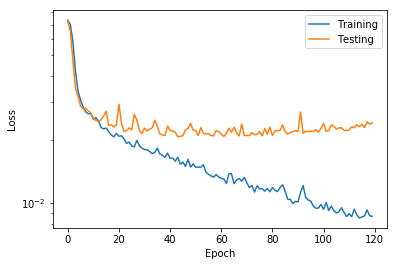

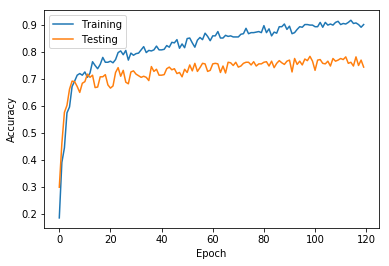

Saving models...


In [14]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn_fashion.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn_fashion,'tailor_cnn_Sfashion', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH+20)

The classification accuracy:  0.744



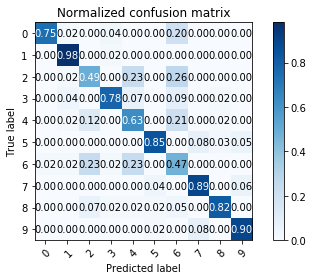

In [15]:
tailored_cnn_fashion = Tailored_CNN_Mnist().to(device)
load_model('tailor_cnn_Sfashion', tailored_cnn_fashion)
y_true, y_pred = get_labels(tailored_cnn_fashion, testloader_cnn, snn=False)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

# Test for SNN with weights from tailored CNN

## Notes on the conv
* kernel size of time should be 1, otherwise it gets convolved as well.
* bias=False
* replace their pool layer with nn.AvgPool3d. The pool they used is a $sum*\theta$ not an average.
* should recieve the Spikes from the previous layer
* the input value should be within [0,1] before they go into the DataLoader
## Pipeline
raw data(B,C,H,W) --- spike generation ---> spike(B,C,H,W,T) --- Conv3d on spikes ---> X(t) for every t of T --- eq 1: LIF, threshold and reset ---> intermediate V(t), the membrane potential --- based on V(t) ---> Spikes for the next layer.

In [16]:
class custmized_SNN_Mnist(nn.Module):
    
    def __init__(self, thetas, leaks=[0,0,0,0,0], V_mins=[0,0,0,0,0]):
        super(custmized_SNN_Mnist, self).__init__()
        self.conv1 = convLayer(1, 3, 5, theta=thetas[0], padding=1)
        self.pool1 = poolLayer(2, theta=thetas[1])
        self.conv2 = convLayer(3, 12, 5, theta=thetas[2],padding=1)        
        self.pool2 = poolLayer(2, theta=thetas[3])
        self.fc1   = denseLayer((5 * 5 * 12), 10, theta=thetas[4])
        
    def forward(self, spikeInput):
        spike_conv1 = self.conv1(spikeInput)
        #print(spike_conv1)
        spike_pool1 = self.pool1(spike_conv1)
        #print(spike_pool1)
        spike_conv2 = self.conv2(spike_pool1)
        #print(spike_conv2.shape)
        spike_pool2 = self.pool2(spike_conv2)
        spike_for_fc1 = spike_pool2.reshape(-1, 5 * 5 * 12, 1, 1, spike_pool2.shape[-1])
        spikeOut = self.fc1(spike_for_fc1)
        
        return spikeOut

### experiment MNIST

In [17]:
# set up hyper params
TIME_BINS = 100

In [18]:
# Dataset and dataLoader instances.
testingSet_M = SpikeDataset(datasetPath = './data', dataset='mnist',TimeBins=TIME_BINS,
                    small=True, train=False)

testLoader_M = DataLoader(dataset=testingSet_M, batch_size=64, shuffle=False, num_workers=4)

* check the performance of a randomly initialized SNN

In [19]:
thetas = [1, 0.99, 1, 0.99, 1]

custmized_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)

The classification accuracy:  0.076



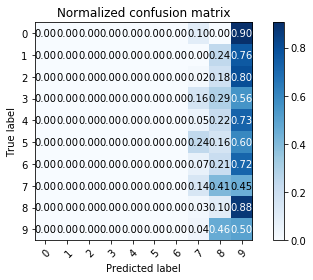

In [20]:
y_true, y_pred = get_labels(custmized_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* now try with the weights learned from tailor_cnn

In [21]:
# script to transport the weights
tailor_cnn_weights = load_dict("tailor_cnn_Smnist")
snn_weights = custmized_snn_mnist.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [22]:
transformed_snn_mnist = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_mnist.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.692



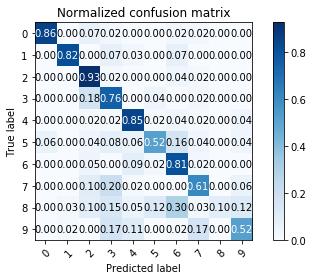

In [23]:
y_true, y_pred = get_labels(transformed_snn_mnist, testLoader_M, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

### experiment FashionMnist

In [24]:
testingSet_F = SpikeDataset(datasetPath = './data', dataset='fashion',TimeBins=TIME_BINS,
                    small=True, train=False)
testLoader_F = DataLoader(dataset=testingSet_F, batch_size=64, shuffle=False, num_workers=4)

* check the performance of a randomly initialized SNN

In [32]:
thetas = [10, 0.7, 0.9, 0.7, 1]

custmized_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)

The classification accuracy:  0.096



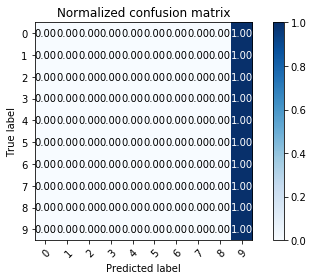

In [33]:
y_true, y_pred = get_labels(custmized_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())

* now try with the weights learned from tailor_cnn

In [34]:
# script to transport the weights
tailor_cnn_weights = load_dict("tailor_cnn_Sfashion")
snn_weights = custmized_snn_fashion.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [35]:
transformed_snn_fashion = custmized_SNN_Mnist(thetas=thetas).to(device)
transformed_snn_fashion.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.572



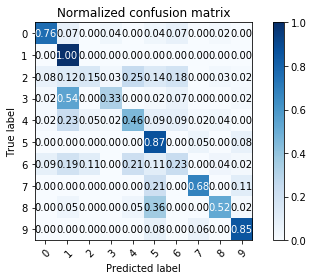

In [36]:
y_true, y_pred = get_labels(transformed_snn_fashion, testLoader_F, snn=True)
test_method(y_true.cpu().numpy(), y_pred.cpu().numpy())